In [ ]:
import torch
import triton
import triton.language as tl

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Naive softmax

In [ ]:
DEVICE

device(type='cuda')

In [ ]:
def naive_softmax(x:torch.Tensor) -> torch.Tensor:
    x_max = x.max(dim = 1)[0]
    z = x - x_max[:, None] # Aligning shapes
    numerator = torch.exp(z)
    denominator = torch.sum(numerator, axis = 1)
    output = numerator / denominator.unsqueeze(1)
    return output

In [30]:
x = torch.Tensor([[2, 3, 10], [1, 1, 2]])
naive_softmax(x)

tensor([[3.3504e-04, 9.1075e-04, 9.9875e-01],
        [2.1194e-01, 2.1194e-01, 5.7612e-01]])

In [47]:
@triton.jit
def softmax_kernel(input_ptr, output_ptr, input_row_stride, output_row_stride, n_cols, BLOCK_SIZE: tl.constexpr):
    # Since the row calculations in softmax are independent, we can parallelize across rows
    row_idx = tl.program_id(0)
    row_start_ptr = input_ptr + row_idx*input_row_stride

    # We choose BLOCK_SIZE as the next power of 2 greater than n_cols
    col_offsets = tl.arange(0,BLOCK_SIZE)

    # Moving to the specific elements within the row
    input_ptrs = row_start_ptr + col_offsets

    mask = col_offsets < n_cols

    row = tl.load(input_ptrs, mask = mask, other= -float("inf"))

    # Maximum for each row
    row_max = tl.max(row, axis=0)

    # Exponentiation
    numerator = tl.exp(row - row_max)

    # Summing the numerator
    denominator = tl.sum(numerator, axis=0)

    softmax_output = numerator / denominator

    # Storing the output
    output_start_ptr = output_ptr + row_idx * output_row_stride
    output_ptrs = output_start_ptr + col_offsets
    tl.store(output_ptrs, softmax_output, mask=mask)

# Potential improvements : Using make_block_ptr to vectorize the operations

In [48]:
def softmax(x):
    n_rows, n_cols = x.shape

    BLOCK_SIZE = triton.next_power_of_2(n_cols)

    # Another trick we can use is to ask the compiler to use more threads per row by increasing the number of warps (`num_warps`) over which each row is distributed. I need to learn more about this and autotuning

    num_warps = 4
    if BLOCK_SIZE >= 2048:
        num_warps = 8
    if BLOCK_SIZE >= 4096:
        num_warps = 16

    y = torch.empty_like(x)

    softmax_kernel[(n_rows,)](x, y, x.stride(0), y.stride(0), n_cols, BLOCK_SIZE, num_warps=num_warps)
    # No need for meta parameters because number of blocks doesn't vary with block size. We are launching one thread block per row

    return y

In [49]:
torch.manual_seed(0)
x = torch.randn(1823, 781, device=DEVICE)
y_triton = softmax(x)
y_torch = torch.softmax(x, axis=1)
assert torch.allclose(y_triton, y_torch), (y_triton, y_torch)

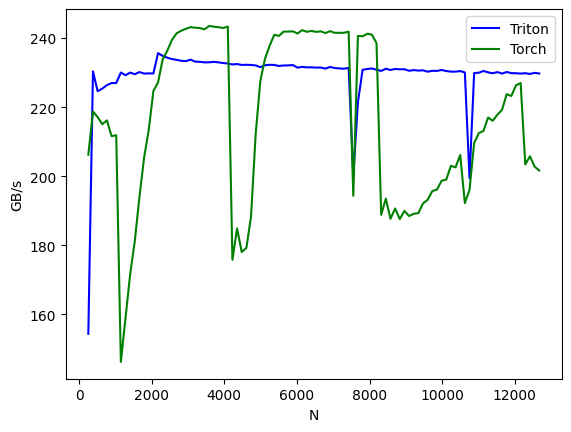

softmax-performance:
          N      Triton       Torch
0     256.0  154.352360  206.218481
1     384.0  230.373836  218.724630
2     512.0  224.627219  217.140883
3     640.0  225.371980  215.076020
4     768.0  226.387502  216.172962
5     896.0  226.983580  211.588821
6    1024.0  226.984760  211.886099
7    1152.0  230.033170  146.205965
8    1280.0  229.250125  158.940876
9    1408.0  230.013784  171.600207
10   1536.0  229.543761  181.275901
11   1664.0  230.159587  194.043756
12   1792.0  229.734956  205.376864
13   1920.0  229.781494  213.445596
14   2048.0  229.756337  224.688991
15   2176.0  235.645851  227.181725
16   2304.0  234.855332  233.849003
17   2432.0  234.321746  236.387370
18   2560.0  233.930284  239.511527
19   2688.0  233.706152  241.397359
20   2816.0  233.430484  242.155505
21   2944.0  233.327317  242.694724
22   3072.0  233.767056  243.173420
23   3200.0  233.182955  243.015046
24   3328.0  233.136953  242.900298
25   3456.0  232.970487  242.549671
26   35

In [50]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N'],
        x_vals=[128 * i for i in range(2, 100)],
        line_arg='provider',
        line_vals=['triton', 'torch'],
        line_names=[
            "Triton",
            "Torch",
        ],
        styles=[('blue', '-'), ('green', '-')],
        ylabel="GB/s",
        plot_name="softmax-performance",
        args={'M': 4096},

    ))
def benchmark(M, N, provider):
    x = torch.randn(M, N, device=DEVICE, dtype=torch.float32)
    stream = getattr(torch, DEVICE.type).Stream()
    getattr(torch, DEVICE.type).set_stream(stream)
    if provider == 'torch':
        ms = triton.testing.do_bench(lambda: torch.softmax(x, axis=-1))
    if provider == 'triton':
        ms = triton.testing.do_bench(lambda: softmax(x))
    gbps = lambda ms: 2 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms)


benchmark.run(show_plots=True, print_data=True)